## 超分辨率 Learning Project

[参考1: Super_Resolution](https://github.com/walkwithfastai/walkwithfastai.github.io/blob/master/nbs/course2020/vision/07_Super_Resolution.ipynb)\
[参考2: superres-gan](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson7-superres-gan.ipynb)

https://zhuanlan.zhihu.com/p/87253140

概要:

* Image -> Image 数据加载方式
* Unet 来实现超分

## Init fast ai 💐🎄🐡

In [2]:
#hide
!pip install -Uq fastai
import fastai
from fastai.vision.all import *
from fastai.vision import *
from fastai.callback import *
from fastai.vision.gan import *
import shutil
import os

from google.colab import drive
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/MyDrive/fast_ai/'

Mounted at /content/gdrive


## Data 💐🎄🐡

In [3]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'
path_gen = path/'image_gen'

### crappify data 💐🐡

In [4]:
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr
        
    def __call__(self, fn):       
        dest = self.path_lr/fn.relative_to(self.path_hr)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

In [5]:
import glob
imgs = [Path(i) for i in glob.glob(str(path_hr)+'/*.jpg')]
parallel(crappifier(path_lr, path_hr), imgs)

(#7390) [None,None,None,None,None,None,None,None,None,None...]

<AxesSubplot:>

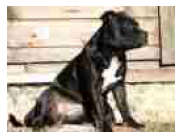

In [6]:
bad_imgs = get_image_files(path_lr)
im1 = PILImage.create(bad_imgs[0])
im1.show()

### load superres initial result for critic

In [7]:
import zipfile
def save_superres_image():
  # zip file
  shutil.make_archive('image_gen', 'zip', path_gen)
  shutil.copy('image_gen.zip', gdrive_path+'image_gen.zip')

def load_superres_images():
  shutil.copy(gdrive_path+'image_gen.zip', 'image_gen.zip')
  with zipfile.ZipFile('image_gen.zip', 'r') as zip_ref:
      zip_ref.extractall(path_gen)

### data loader for superres gan

In [8]:
def get_dls(bs:int, size:int):
  dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                    get_items=get_image_files,
                    get_y=lambda x: path_hr/x.name,
                    splitter=RandomSplitter(),
                    item_tfms=Resize(size),
                    batch_tfms=[*aug_transforms(max_zoom=2.),
                                Normalize.from_stats(*imagenet_stats)])
  dls = dblock.dataloaders(path_lr, bs=bs, path=path)
  dls.c = 3
  return dls

### data loader for critic

In [33]:
# https://docs.fast.ai/tutorial.datablock.html
def get_crit_dls(image_list, bs:int, size:int):
  dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                     splitter=RandomSplitter(),
                     item_tfms=Resize(size),
                     # normalize.from_stats很重要, 学习速度快了很多
                     #batch_tfms=[*aug_transforms(max_zoom=2.), Normalize.from_stats(*imagenet_stats)],
                     batch_tfms=Normalize.from_stats(*imagenet_stats),
                     get_x = lambda imgs: imgs,
                     get_y = parent_label)
  return dblock.dataloaders(image_list, bs=bs, path=path)

## Learner

### Unet superres learner

一些参数的解释:
* `wd`\
  wd is the default weight decay used when training the model.
* `norm_type` \
  [Batch Normalization Type](https://towardsdatascience.com/different-normalization-layers-in-deep-learning-1a7214ff71d6)

* `blur`\
  [Super-Resolution using Convolutional Neural Networks without Any Checkerboard Artifacts](https://arxiv.org/abs/1806.02658)  where the authors add a little bit of blur to completely get rid of checkerboard artifacts.

* `self_attension`\
  Self-attention layer as introduced in [Self-Attention Generative Adversarial Networks](https://arxiv.org/abs/1805.08318)

* `y_range`\
  y_range is passed, the function adds a SigmoidRange to that range

In [10]:
wd, y_range, loss_gen, bbone = 1e-3, (-3., 3.), MSELossFlat(), resnet34

In [11]:
def create_gen_learner(dls_gen):
  return unet_learner(dls_gen, bbone, wd=wd, loss_func=loss_gen, 
                      blur=True, norm_type=NormType.Weight,
                      self_attention=True, y_range=y_range)

In [12]:
def save_learner(learner_obj, fname):
  path = learner_obj.save(fname)
  shutil.copy(path, gdrive_path+fname+'.pth')

### Critic Learner

BCE: Binary Cross Entropy
$$
l = -w[y\cdot \log x + (1-y) \cdot\log (1-x))]
$$
BCEWithLogitsLoss 自带sigmoid
$$
l = -w[y\cdot \log \sigma(x) + (1-y) \cdot \log(1-\sigma(x))]
$$

这里$\sigma(x) = \frac{1}{1+e^{-x}}$ sigmoid 函数.

参考: [Loss function — CrossEntropyLoss vs BCELoss in Pytorch; Softmax vs sigmoid; Loss calculation](https://medium.com/dejunhuang/learning-day-57-practical-5-loss-function-crossentropyloss-vs-bceloss-in-pytorch-softmax-vs-bd866c8a0d23)

这里使用AdaptiveLoss是因为gan_critic()得到的是一个动态大小的输出(不同大小的图片输出大小也不一样). [why-use-adaptive-loss-for-gan](https://forums.fast.ai/t/why-use-adaptive-loss-for-gan-critic/52956)

In [13]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

def create_crit_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)    

## PreTrain Unet For Superres 💐

### Train Unet

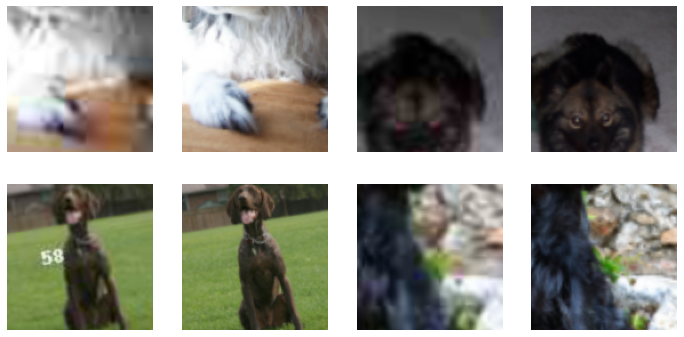

In [14]:
dls_gen = get_dls(32, 128)
dls_gen.show_batch(max_n=4)

In [15]:
# size of batch, batch size, dataset size
len(dls_gen.train), dls_gen.bs, len(dls_gen.dataset.items)

(184, 32, 5912)

In [16]:
# input, output image size
ob = dls_gen.one_batch()
ob[0].shape, ob[1].shape

(torch.Size([32, 3, 128, 128]), torch.Size([32, 3, 128, 128]))

In [17]:
learn_gen = create_gen_learner(dls_gen)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [18]:
learn_gen.fit_one_cycle(2, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,time
0,0.067831,0.051185,01:49
1,0.040885,0.039462,01:44


In [19]:
learn_gen.unfreeze()

In [20]:
learn_gen.fit_one_cycle(3, slice(1e-6, 1e-3), wd=wd)

epoch,train_loss,valid_loss,time
0,0.038702,0.037165,01:48
1,0.035107,0.035131,01:48
2,0.034024,0.033886,01:48


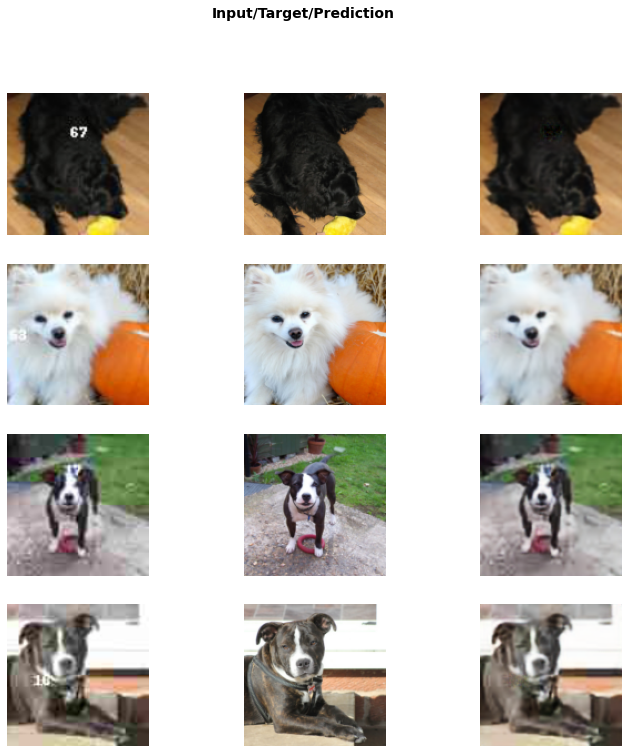

In [21]:
learn_gen.show_results(max_n=4, figsize=(12,12))

### Save Result

In [22]:
save_learner(learn_gen, 'gen-pre2')

In [23]:
path_gen.mkdir(exist_ok=True)
def save_preds(dl, learn):
  "Save away predictions"
  names = dl.dataset.items
  
  preds,_ = learn.get_preds(dl=dl)
  for i,pred in enumerate(preds):
      dec = dl.after_batch.decode((TensorImage(pred[None]),))[0][0]
      arr = dec.numpy().transpose(1,2,0).astype(np.uint8)
      Image.fromarray(arr).save(path_gen/names[i].name)

dl = dls_gen.train.new(shuffle=False, drop_last=False, 
                       after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

save_preds(dl, learn_gen)

In [24]:
save_superres_image()

## PreTrain Critic 🎄

In [34]:
if not path_gen.exists():
    load_superres_images()
image_list = get_image_files(path_gen) + get_image_files(path_hr)

In [35]:
dls_crit = get_crit_dls(image_list, 32, 128)

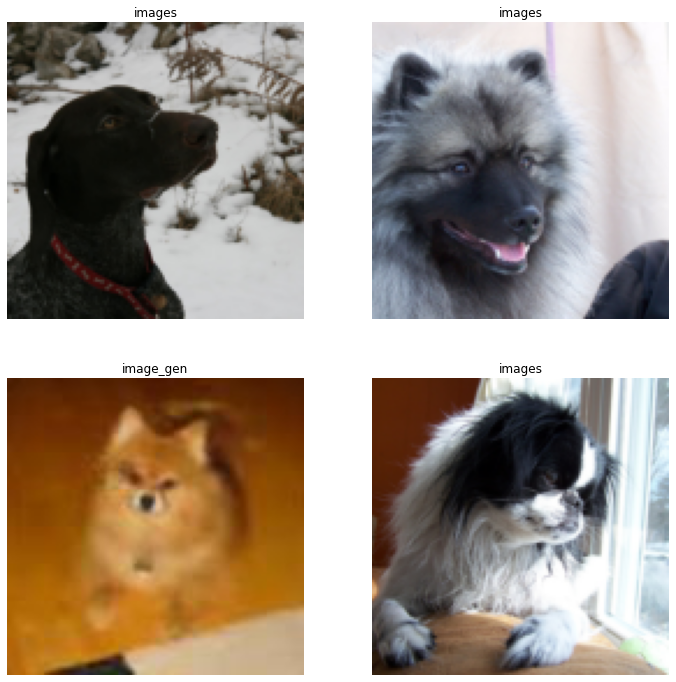

In [36]:
dls_crit.show_batch(max_n=4, figsize=(12,12))

### critic learner

In [37]:
learn_crit = create_crit_learner(dls_crit, accuracy_thresh_expand)

In [38]:
#learn_crit.summary()

In [39]:
#model = gan_critic()
#model

In [40]:
learn_crit.fit_one_cycle(6, 1e-3, wd=1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.688754,0.689562,0.562752,03:20
1,0.624690,0.530877,0.734526,03:20
2,0.118664,0.087992,0.975023,03:19
3,0.049708,0.034130,0.990601,03:20
4,0.020882,0.014145,0.998075,03:17
5,0.014095,0.008067,0.997970,03:17


In [41]:
save_learner(learn_crit, 'crit-pre2')

## GAN 🐡

In [44]:
if not path_gen.exists():
    load_superres_images()
image_list = get_image_files(path_gen) + get_image_files(path_hr)
dls_crit = get_crit_dls(image_list, bs=32, size=128)

In [46]:
learn_crit = create_crit_learner(dls_crit, metrics=None).load('crit-pre2')

In [47]:
dls_gen = get_dls(32, 128)
learn_gen = create_gen_learner(dls_gen).load('gen-pre2')

GAN Learner

* GANDiscriminativeLR对生成器和鉴别器使用两种不同的学习率.
* discrimitor as needed until its loss is back to <0.65 then do an iteration of generator

In [48]:
class GANDiscriminativeLR(Callback):
    "`Callback` that handles multiplying the learning rate by `mult_lr` for the critic."
    def __init__(self, mult_lr=5.): self.mult_lr = mult_lr

    def begin_batch(self):
        "Multiply the current lr if necessary."
        if not self.learn.gan_trainer.gen_mode and self.training: 
            self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']*self.mult_lr)

    def after_batch(self):
        "Put the LR back to its value if necessary."
        if not self.learn.gan_trainer.gen_mode: self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']/self.mult_lr)

In [49]:
switcher = AdaptiveGANSwitcher(critic_thresh=.65)

In [50]:
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(Adam, mom=0.), cbs=GANDiscriminativeLR(mult_lr=5.))

In [51]:
learn.fit(10, 1e-4, wd=wd)

/usr/local/lib/python3.8/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.8/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.8/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,gen_loss,crit_loss,time
0,3.292538,7.587264,7.587264,0.507560,03:27
1,3.201594,7.587137,7.587137,0.297439,03:29
2,3.203810,7.587076,7.587076,0.425189,03:27
3,3.165098,7.587042,7.587042,0.656848,03:27
4,3.215218,7.587022,7.587022,0.441847,03:30
5,3.112905,7.587010,7.587010,0.333429,03:29
6,3.255090,7.587001,7.587001,0.575577,03:28
7,3.156033,7.586998,7.586998,0.580365,03:31
8,3.302766,7.586996,7.586996,0.345965,03:28
9,3.205251,7.586994,7.586994,0.526413,03:29


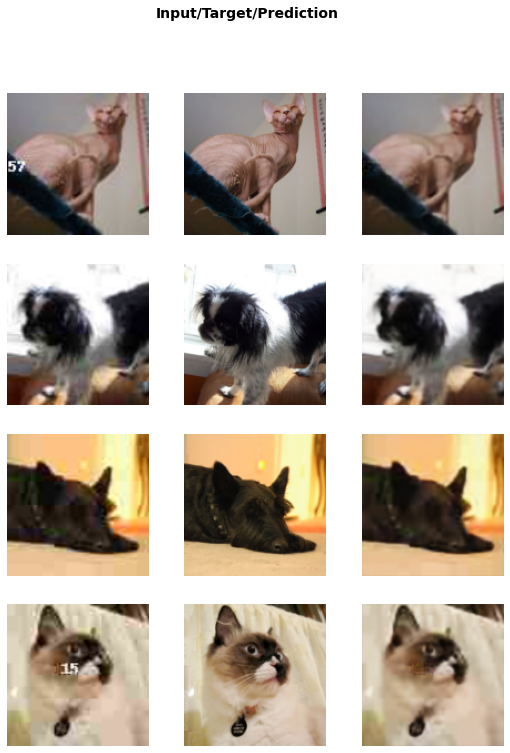

In [52]:
learn.show_results(max_n=4)